In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import cross_val_score
from sklearn import svm

import dionysus as d
import sklearn_tda as tda

from biomarker.data_collection import *

Cython not found--WassersteinDistance not available
Gudhi not found--GraphInducedComplex not available
data_collection


In [2]:
EXCLUDE_KEYS = [206, 205, 184, 183, 82, 81, 45]
TEST_KEYS = [217, 216]#, 215, 214, 213, 212, 211, 210, 209]
NUM_TEST = 10
SIGMA = 1

C = 1
EPSILON = 0.1
GAMMA = 0.1
LIM = 5
MUL = 10

In [3]:
def compute_diagram(points, k=3):
    r = np.max(pdist(points, 'euclidean'))
    f = d.fill_rips(points, k, r)
    m = d.homology_persistence(f)
    return d.init_diagrams(m, f)

def get_max_diag_dim(dgms, h=1):
    m = 0
    for d in dgms:
        n = len(d[h])
        if n > m:
            m = n
    return m

def kernelize_diagrams_rbf(dgms, h=1, sigma=SIGMA, default=10):
    D = np.zeros(shape=(len(dgms), len(dgms)))
    for i in range(len(dgms)):
        print('step: ', i)
        for j in range(len(dgms)):
            if i == j:
                D[i,j] = 0.0
            else:
                xi = np.zeros(((len(dgms[i][h]) if len(dgms[i][h]) > len(dgms[j][h]) else len(dgms[j][h])), 2))
                xj = np.zeros(xi.shape)
                if xj.shape[0] > 0:
                    for ip in range(len(dgms[i][h])):
                        xi[ip,0] = dgms[i][h][ip].birth
                        xi[ip,1] = dgms[i][h][ip].death
                    for jp in range(len(dgms[j][h])):
                        xj[jp,0] = dgms[j][h][ip].birth
                        xj[jp,1] = dgms[j][h][ip].death
                    xi[xi[:,1] >= 1E108] = 0
                    xj[xj[:,1] >= 1E108] = 0
                    D[i,j] = np.exp(np.power((np.linalg.norm(xi - xj, 2)), 2)/(2*sigma))
    #                 D[D >= 1E108] = 0
                else:
                    D[i,j] = 0
                D = np.nan_to_num(D)
    return D

def kernelize_diagrams(dgms, h=1, sigma=SIGMA):
    D = np.zeros(shape=(len(dgms), len(dgms)))
    for i in range(len(dgms)):
        print('step: ', i)
        for j in range(len(dgms)):
            if i == j:
                D[i,j] = 0.0
            else:
                D[i,j] = d.bottleneck_distance(dgms[i][h], dgms[j][h])
#                 D[i,j] = np.exp(d.wasserstein_distance(dgms[i][h], dgms[j][h], q=2)/2*sigma)
    D = np.nan_to_num(D)
    return D


def compute_sample_weights(y, lim=LIM, mul=MUL):
    ret = np.ones(y.shape[0])
    for i in range(y.shape[0]):
        v = y[i]
        if v < lim:
            ret[i] = (lim-v)*mul
    return ret

def create_test_matrices(use_master_only=False):
    excel = parse_master_file(exclude_keys=EXCLUDE_KEYS)
    
    excel_train = excel
    L_train = get_filename_list(excel_train['Associated data'])
    y_train = excel_train['Output: logK'].values
    y_buck_train = excel_train['Output: logKbucket'].values
    
    x10_x17_train = excel_train.iloc[:, 3:-2]
    master_train, master_names = prepare_master(x10_x17_train)
    
    if use_master_only:
        return (master_train, y_train)
    
    x1_train, x1_dims = create_x1_matrix(L_train, return_dims=True)
    x4_train, x4_dims = create_x4_matrix(L_train, return_dims=True)
    x5_train, x5_dims = create_x5_matrix(L_train, return_dims=True)
    x6_train, x6_dims = create_x6_matrix(L_train, return_dims=True)
    x7_train, x7_dims = create_x7_matrix(L_train, return_dims=True)
    
    
    X_train = np.hstack((x1_train,x4_train,x5_train,x6_train,x7_train, master_train))
    
    
#     K = rbf_kernel(X)
    
    return (X_train, y_train)

def create_train_test_matrices(train_keys, test_keys):
    excel = parse_master_file(exclude_keys=EXCLUDE_KEYS)
    test_idxs = list(excel[np.isin(excel['Key'], test_keys)].index)
    excel_test = excel.iloc[test_idxs]
    L_test = get_filename_list(excel_test['Associated data'])
    y_test = excel_test['Output: logK'].values
    y_buck_test = excel_test['Output: logKbucket'].values
    
    excel_train = excel.drop(test_idxs, axis=0)
    L_train = get_filename_list(excel_train['Associated data'])
    y_train = excel_train['Output: logK'].values
    y_buck_train = excel_train['Output: logKbucket'].values
    
    x1_train, x1_dims = create_x1_matrix(L_train, return_dims=True)
    x4_train, x4_dims = create_x4_matrix(L_train, return_dims=True)
    x5_train, x5_dims = create_x5_matrix(L_train, return_dims=True)
    x6_train, x6_dims = create_x6_matrix(L_train, return_dims=True)
    x7_train, x7_dims = create_x7_matrix(L_train, return_dims=True)
    
    x1_test = create_x1_matrix(L_test, max_dims=x1_dims)
    x4_test = create_x4_matrix(L_test, max_dims=x4_dims)
    x5_test = create_x5_matrix(L_test, max_dims=x5_dims)
    x6_test = create_x6_matrix(L_test, max_dims=x6_dims)
    x7_test = create_x7_matrix(L_test, max_dims=x7_dims)
    
    x10_x17_train = excel_train.iloc[:, 3:-2]
    master_train, master_names = prepare_master(x10_x17_train)
    
    x10_x17_test = excel_test.iloc[:, 3:-2]
    master_test, master_names = prepare_master(x10_x17_test)
    
    X_train = np.hstack((x1_train,x4_train,x5_train,x6_train,x7_train))
    X_test = np.hstack((x1_test, x4_test, x5_test, x6_test, x7_test))
    
    X = np.vstack((X_train,X_test))
    K = rbf_kernel(X)
    X_train = K[:len(y_train), :len(y_train)]
    X_test = K[len(y_train):, :len(y_train)]
    
    return (X_train, y_train), (X_test, y_test)

def create_train_test_diagram_kernels(train_keys, test_keys, h=1):
    excel = parse_master_file(exclude_keys=EXCLUDE_KEYS)
    test_idxs = list(excel[np.isin(excel['Key'], test_keys)].index)
    excel_test = excel.iloc[test_idxs]
    L_test = get_filename_list(excel_test['Associated data'])
    y_test = excel_test['Output: logK'].values
    y_buck_test = excel_test['Output: logKbucket'].values
    
    excel_train = excel.drop(test_idxs, axis=0)
    L_train = get_filename_list(excel_train['Associated data'])
    y_train = excel_train['Output: logK'].values
    y_buck_train = excel_train['Output: logKbucket'].values
    
    print('Computing Training Diagrams')
    diags_train = []
    for l in L_train:
        diags_train.append(compute_diagram(parse_x1(l)[['X', 'Y', 'Z']].values))
    for i in range(len(diags_train)):
        if len(diags_train[i][h]) == 0:
            diags_train[i] = np.array([[0,0]])
        else:
            diags_train[i] = np.array([[pt.birth,pt.death] for pt in diags_train[i][h]])
    
    print('Computing Test Diagrams')
    diags_test = []
    for l in L_test:
        diags_test.append(compute_diagram(parse_x1(l)[['X', 'Y', 'Z']].values))
    for i in range(len(diags_test)):
        if len(diags_test[i][h]) == 0:
            diags_test[i] = np.array([[0,0]])
        else:
            diags_test[i] = np.array([[pt.birth,pt.death] for pt in diags_test[i][h]])
    
    print('Computing Kernel')
    
    dd = diags_train + diags_test
    SW = tda.SlicedWassersteinKernel(num_directions=1, bandwidth=1.)
    
    D = SW.fit_transform(dd)
    
    D_train = D[:len(y_train), :len(y_train)]
    D_test = D[len(y_train):, :len(y_train)]
    return (D_train, y_train), (D_test, y_test)
      
    
def create_test_diagram_kernels(h=1):
    excel = parse_master_file(exclude_keys=EXCLUDE_KEYS)
    excel_test = excel
    L_test = get_filename_list(excel_test['Associated data'])
    y_test = excel_test['Output: logK'].values
    y_buck_test = excel_test['Output: logKbucket'].values
    
    print('Computing Test Diagrams')
    diags_test = []
    for l in L_test:
        diags_test.append(compute_diagram(parse_x1(l)[['X', 'Y', 'Z']].values))
    for i in range(len(diags_test)):
        if len(diags_test[i][h]) == 0:
            diags_test[i] = np.array([[0,0]])
        else:
            diags_test[i] = np.array([[pt.birth,pt.death] for pt in diags_test[i][h]])
    
    print('Computing Kernel')
    
    dd = diags_test
    SW = tda.SlicedWassersteinKernel(num_directions=1, bandwidth=1.)
    
    D = SW.fit_transform(dd)
    return (D, y_test)
      

In [4]:
excel = parse_master_file(exclude_keys=EXCLUDE_KEYS).reset_index()
keys = excel['Key']

[3, 9]


In [5]:
test_set = create_test_diagram_kernels()
D = test_set[0]
y = test_set[1]
print(D.shape)

[3, 9]
Computing Test Diagrams
Computing Kernel
(196, 196)


In [6]:
test_set = create_test_matrices(use_master_only=False)
X = test_set[0]
print(X.shape)

[3, 9]
(196, 1074)


In [7]:
K = np.hstack((D, X))

In [8]:
Gammas = [1e-4, 1e-2, 1e-1, 1, 10, 'auto']
Cs = [0.1, 1, 10, 20, 50]
Epsilons = [1e-4, 1e-2, 1e-1, 1, 10]
best_params = [0,0,0]
best_score = -float('inf')
best_cvs = None
for gamma in Gammas:
    for c in Cs:
        for eps in Epsilons:
            clf = svm.SVR(kernel='rbf', epsilon=eps, C=c, gamma=gamma)
            sws = compute_sample_weights(y)
            cvs = cross_val_score(clf, K, y, cv=5, scoring='neg_median_absolute_error', fit_params={'sample_weight':sws})
            print('gamma: {}, c: {}, epsilon: {}, Mean Cross-Validation Score: {}, Stddev: {}'.format(gamma, c, eps, cvs.mean(), cvs.std()))
            if cvs.mean() > best_score:
                best_score = cvs.mean()
                best_cvs = cvs
                best_params = [gamma, c, eps]

gamma: 0.0001, c: 0.1, epsilon: 0.0001, Mean Cross-Validation Score: -2.573356239957449, Stddev: 0.7620580313634674
gamma: 0.0001, c: 0.1, epsilon: 0.01, Mean Cross-Validation Score: -2.572592563755153, Stddev: 0.7615216811282343
gamma: 0.0001, c: 0.1, epsilon: 0.1, Mean Cross-Validation Score: -2.554951728017167, Stddev: 0.7572435322636962
gamma: 0.0001, c: 0.1, epsilon: 1, Mean Cross-Validation Score: -2.57580048306487, Stddev: 0.7834481119025146
gamma: 0.0001, c: 0.1, epsilon: 10, Mean Cross-Validation Score: -2.3249999999999997, Stddev: 0.9895958771134812
gamma: 0.0001, c: 1, epsilon: 0.0001, Mean Cross-Validation Score: -1.8140524597776426, Stddev: 0.4331066489614135
gamma: 0.0001, c: 1, epsilon: 0.01, Mean Cross-Validation Score: -1.81367400977974, Stddev: 0.43234897040826187
gamma: 0.0001, c: 1, epsilon: 0.1, Mean Cross-Validation Score: -1.783518347343336, Stddev: 0.4513020191565425
gamma: 0.0001, c: 1, epsilon: 1, Mean Cross-Validation Score: -1.674465527117274, Stddev: 0.5322

gamma: 1, c: 0.1, epsilon: 0.0001, Mean Cross-Validation Score: -2.752156451314929, Stddev: 0.7648269658244828
gamma: 1, c: 0.1, epsilon: 0.01, Mean Cross-Validation Score: -2.7488929006344938, Stddev: 0.7640850080268278
gamma: 1, c: 0.1, epsilon: 0.1, Mean Cross-Validation Score: -2.719869230224687, Stddev: 0.7577213384405003
gamma: 1, c: 0.1, epsilon: 1, Mean Cross-Validation Score: -2.598352720240361, Stddev: 0.7752635365550731
gamma: 1, c: 0.1, epsilon: 10, Mean Cross-Validation Score: -2.3249999999999997, Stddev: 0.9895958771134812
gamma: 1, c: 1, epsilon: 0.0001, Mean Cross-Validation Score: -1.712243085642554, Stddev: 0.4657880561010378
gamma: 1, c: 1, epsilon: 0.01, Mean Cross-Validation Score: -1.7118249866409236, Stddev: 0.4661974954200947
gamma: 1, c: 1, epsilon: 0.1, Mean Cross-Validation Score: -1.7070651738363565, Stddev: 0.4706049664822806
gamma: 1, c: 1, epsilon: 1, Mean Cross-Validation Score: -1.667516611711902, Stddev: 0.5321750599260033
gamma: 1, c: 1, epsilon: 10, 

In [9]:
print(best_score, best_params)

-1.6177191750313156 ['auto', 50, 0.1]


In [10]:
results = []
for i in range(D.shape[0]):
    mask = np.ones(D.shape, dtype=bool)
    mask[i,i] = False
    y_train = np.delete(y, i, 0)
    y_test = y[i]
    D_train = np.delete(np.delete(D, i, axis=0), i, axis=1)
    D_test = np.delete(D[i], i, axis=0).reshape(1,-1)
    
    X_train = np.delete(X, i, axis=0)
    X_test = X[i].reshape(1,-1)
    
    K_train = np.hstack((D_train,X_train))
    K_test = np.hstack((D_test,X_test))
    
    clf = svm.SVR(kernel='rbf', epsilon=best_params[2], C=best_params[1], gamma=best_params[0])
    sws = compute_sample_weights(y_train)
    clf.fit(K_train,y_train, sample_weight=sws)
    prediction = clf.predict(K_test)
    results.append({'predicted':prediction[0], 'actual':y_test, 'key':keys[i]})

In [11]:
res_df = pd.DataFrame(results)
res_df.tail(10)

,actual,key,predicted
186,7.95,211,6.214221
187,5.52,212,6.229374
188,8.74,213,6.208846
189,8.14,214,6.212947
190,4.00,215,6.239713
191,6.54,216,6.223798
192,0.00,217,6.267238
193,0.00,218,6.267235
194,0.00,219,6.267233
195,0.00,220,6.267236


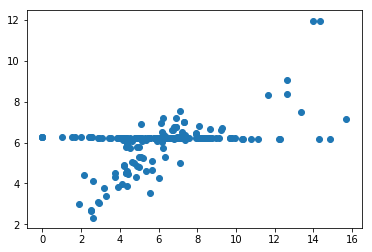

In [12]:
plt.scatter(res_df['actual'], res_df['predicted'])

In [13]:
res_df.to_csv('../data/results/actual_v_predicted_all.csv', sep=',')

In [14]:
# just features, no homology
Gammas = [1e-4, 1e-2, 1e-1, 1, 10, 'auto']
Cs = [0.1, 1, 10, 20, 50]
Epsilons = [1e-4, 1e-2, 1e-1, 1, 10]
best_params = [0,0,0]
best_score = -float('inf')
best_cvs = None
for gamma in Gammas:
    for c in Cs:
        for eps in Epsilons:
            clf = svm.SVR(kernel='rbf', epsilon=eps, C=c, gamma=gamma)
            sws = compute_sample_weights(y)
            cvs = cross_val_score(clf, X, y, cv=5, scoring='neg_median_absolute_error', fit_params={'sample_weight':sws})
            print('gamma: {}, c: {}, epsilon: {}, Mean Cross-Validation Score: {}, Stddev: {}'.format(gamma, c, eps, cvs.mean(), cvs.std()))
            if cvs.mean() > best_score:
                best_score = cvs.mean()
                best_cvs = cvs
                best_params = [gamma, c, eps]

gamma: 0.0001, c: 0.1, epsilon: 0.0001, Mean Cross-Validation Score: -2.5733062222609218, Stddev: 0.762039867764516
gamma: 0.0001, c: 0.1, epsilon: 0.01, Mean Cross-Validation Score: -2.5725438679361363, Stddev: 0.7615060473316093
gamma: 0.0001, c: 0.1, epsilon: 0.1, Mean Cross-Validation Score: -2.554935550578681, Stddev: 0.7572418559147047
gamma: 0.0001, c: 0.1, epsilon: 1, Mean Cross-Validation Score: -2.5757951159366494, Stddev: 0.7834478346218071
gamma: 0.0001, c: 0.1, epsilon: 10, Mean Cross-Validation Score: -2.3249999999999997, Stddev: 0.9895958771134812
gamma: 0.0001, c: 1, epsilon: 0.0001, Mean Cross-Validation Score: -1.8140464709363193, Stddev: 0.43310588219512514
gamma: 0.0001, c: 1, epsilon: 0.01, Mean Cross-Validation Score: -1.8136500584571327, Stddev: 0.43234353682705084
gamma: 0.0001, c: 1, epsilon: 0.1, Mean Cross-Validation Score: -1.783501177785665, Stddev: 0.4512832427798246
gamma: 0.0001, c: 1, epsilon: 1, Mean Cross-Validation Score: -1.6744552986274095, Stddev:

gamma: 1, c: 0.1, epsilon: 0.0001, Mean Cross-Validation Score: -2.752156451314929, Stddev: 0.7648269658244828
gamma: 1, c: 0.1, epsilon: 0.01, Mean Cross-Validation Score: -2.7488929006344938, Stddev: 0.7640850080268278
gamma: 1, c: 0.1, epsilon: 0.1, Mean Cross-Validation Score: -2.719869230224687, Stddev: 0.7577213384405003
gamma: 1, c: 0.1, epsilon: 1, Mean Cross-Validation Score: -2.598352720240361, Stddev: 0.7752635365550731
gamma: 1, c: 0.1, epsilon: 10, Mean Cross-Validation Score: -2.3249999999999997, Stddev: 0.9895958771134812
gamma: 1, c: 1, epsilon: 0.0001, Mean Cross-Validation Score: -1.712243085642554, Stddev: 0.4657880561010378
gamma: 1, c: 1, epsilon: 0.01, Mean Cross-Validation Score: -1.7118249866409236, Stddev: 0.4661974954200947
gamma: 1, c: 1, epsilon: 0.1, Mean Cross-Validation Score: -1.7070651738363565, Stddev: 0.4706049664822806
gamma: 1, c: 1, epsilon: 1, Mean Cross-Validation Score: -1.667516611711902, Stddev: 0.5321750599260033
gamma: 1, c: 1, epsilon: 10, 

In [15]:
results_X = []
for i in range(X.shape[0]):
    y_train = np.delete(y, i, 0)
    y_test = y[i]
    
    X_train = np.delete(X, i, axis=0)
    X_test = X[i].reshape(1,-1)
    
    clf = svm.SVR(kernel='rbf', epsilon=best_params[2], C=best_params[1], gamma=best_params[0])
    sws = compute_sample_weights(y_train)
    clf.fit(X_train,y_train, sample_weight=sws)
    prediction = clf.predict(X_test)
    results_X.append({'predicted':prediction[0], 'actual':y_test, 'key':keys[i]})

In [16]:
X_df = pd.DataFrame(results_X)
X_df.tail(10)

,actual,key,predicted
186,7.95,211,6.223815
187,5.52,212,6.239624
188,8.74,213,6.218661
189,8.14,214,6.222565
190,4.00,215,6.249516
191,6.54,216,6.232982
192,0.00,217,6.275551
193,0.00,218,6.275551
194,0.00,219,6.275551
195,0.00,220,6.275551


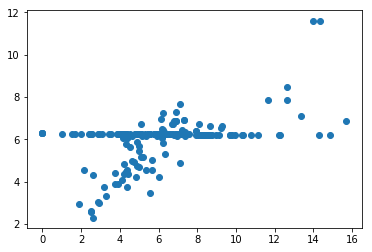

In [17]:
plt.scatter(X_df['actual'], X_df['predicted'])

In [18]:
# X_df.to_csv('../data/results/actual_v_predicted_all.csv', sep=',')